In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
from matplotlib import style
import string
from collections import Counter
import sys
import pickle
import glob
from keras.layers import Dense
from keras.layers import SeparableConv1D,MaxPooling1D, LSTM
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [ ]:
# Import files from google drive
from google.colab import files
uploaded = files.upload()

Saving Dataset.zip to Dataset.zip


In [ ]:
# Unzip dataset
!unzip Dataset

Archive:  Dataset.zip
  inflating: Dataset/mHealth_subject1.log  
  inflating: Dataset/mHealth_subject10.log  
  inflating: Dataset/mHealth_subject2.log  
  inflating: Dataset/mHealth_subject3.log  
  inflating: Dataset/mHealth_subject4.log  
  inflating: Dataset/mHealth_subject5.log  
  inflating: Dataset/mHealth_subject6.log  
  inflating: Dataset/mHealth_subject7.log  
  inflating: Dataset/mHealth_subject8.log  
  inflating: Dataset/mHealth_subject9.log  


In [ ]:
# Import relevant libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import _pickle as cPickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pickle
import sys
import os

files=os.listdir("Dataset/")
folder="Dataset/"

In [ ]:
features=[]
labels=[]

# loop over all files to get features and labels
with tqdm(total=len(files)) as pbar:
    for f1 in files:
        name=folder+f1
        f = open(name, 'r')
        x=f.readline()
        while(x):
            x=x.split()
            labels.append(int(x[-1]))
            del x[-1]
            sublist=[]
            for val in x:
                sublist.append(val)
            features.append(np.array(sublist))
            x=f.readline()
        pbar.update(1)

# Convert to an array
features=np.array(features)
labels=np.array(labels)

# Print shape of features and labels
print(features.shape)
print(labels.shape)

# Print unique labels
print(np.unique(labels))

# saving for future use
with open("features", 'wb') as fp:
    pickle.dump(features, fp)

with open("labels", 'wb') as fp:
    pickle.dump(labels, fp)

100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


(1215745, 23)
(1215745,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [ ]:
# getting data
with open('features', 'rb') as fp:
    X=pickle.load(fp)

with open('labels', 'rb') as fp:
    y=pickle.load(fp)

In [ ]:
# encoding labels to one hot form
oh=OneHotEncoder()
y=oh.fit_transform(np.reshape(y,(-1,1)))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [ ]:
# splitting data into training and testing
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42, shuffle=True)

# X_train=np.expand_dims(X_train,axis=2)
# X_test=np.expand_dims(X_test,axis=2)

W0821 10:29:39.661973 140433378301824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 10:29:39.702390 140433378301824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 10:29:39.709736 140433378301824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0821 10:29:39.798866 140433378301824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0821 10:29:39.942115 140433378301824 deprecation_wrappe

Train on 972596 samples, validate on 243149 samples
Epoch 1/20
972596/972596 [==============================] - 155s 160us/step - loss: 6.3460 - val_loss: 3.8006
Epoch 2/20
972596/972596 [==============================] - 150s 154us/step - loss: 3.3630 - val_loss: 3.1941
Epoch 3/20
972596/972596 [==============================] - 148s 152us/step - loss: 3.1056 - val_loss: 3.0011
Epoch 4/20
972596/972596 [==============================] - 145s 149us/step - loss: 2.9377 - val_loss: 2.7768
Epoch 5/20
972596/972596 [==============================] - 146s 151us/step - loss: 2.8067 - val_loss: 2.7344
Epoch 6/20
972596/972596 [==============================] - 146s 150us/step - loss: 2.7238 - val_loss: 2.8169
Epoch 7/20
972596/972596 [==============================] - 147s 151us/step - loss: 2.6512 - val_loss: 2.7049
Epoch 8/20
972596/972596 [==============================] - 146s 150us/step - loss: 2.5786 - val_loss: 2.5186
Epoch 9/20
972596/972596 [==============================] - 149s 153

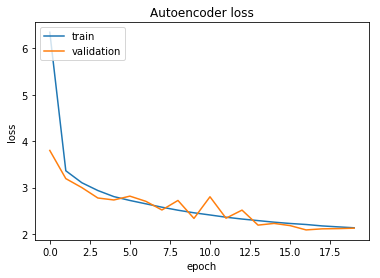

In [ ]:
# Autoencoder
input = Input(shape=(23,))

d=Dense(128, activation='relu')(input)
d=Dense(64, activation='relu')(d)

# learn a representation (encoding) for a set of data
d=Dense(8, activation='relu',name='encoding')(d)

d=Dense(64, activation='relu')(d)
d=Dense(128, activation='relu')(d)

# Linear (i.e. identity) activation function
d=Dense(23, activation='linear')(d)

model = Model(inputs=input, outputs=d)

# defining learning rate and optimizer
adam=Adam(lr=0.0005)

# compiling model
model.compile(optimizer=adam, loss='mse')

# fit model, define batch size and number of epochs
history=model.fit(X_train,X_train,batch_size=32, epochs=20,validation_data=(X_test,X_test))

# saving model
model.save('ae.h5')

with open("OH", 'wb') as fp:
    pickle.dump(oh, fp)

# plotting stats of model
print(history.history.keys())

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Autoencoder loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("ae-loss.png")

with open("X_test-AE", 'wb') as fp:
    pickle.dump(X_test, fp)

with open("y_test-AE", 'wb') as fp:
    pickle.dump(y_test, fp)

In [ ]:
print(model.input)

Tensor("input_1:0", shape=(?, 23), dtype=float32)


In [ ]:
print(model.outputs)

[<tf.Tensor 'dense_5/BiasAdd:0' shape=(?, 23) dtype=float32>]


In [ ]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 23)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3072      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
encoding (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 23)                2967      
Total para

In [ ]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Autoencoder Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("ae-acc.png")

In [ ]:
#getting data
with open('features', 'rb') as fp:
    X=pickle.load(fp)

with open('labels', 'rb') as fp:
    y=pickle.load(fp)
    

In [ ]:
# Get features from the AutoEncoder model

# call previous model
#model=load_model('ae.h5')
layer_name = 'encoding'
intermediate_layer_model = Model(inputs=model.input,
                            outputs=model.get_layer(layer_name).output)

# convert predicted model to an array to identify features
newfeatures=np.array(intermediate_layer_model.predict(X))

# print shape of predicted new features
print(newfeatures.shape)

# splitting predicted new features into training and testing
X_train, X_test, y_train, y_test=train_test_split(newfeatures,y,test_size=0.2, random_state=42, shuffle=True)

print(y_train.shape)

# Write a pickled representation of new features to ae_features.
with open("ae_features", 'wb') as fp:
    pickle.dump(newfeatures, fp)

# Import
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier - identify number of trees (40) + no. of processors (4) allowed to use
clf=RandomForestClassifier(n_estimators=40,n_jobs=4)

# fit the training data
clf.fit(X_train,y_train)

# Print Accuracy
print("Testing Accuracy after AutoEncoder and Random Forest: {}%".format(100*clf.score(X_test,y_test)))

(1215745, 8)
(972596,)
Testing Accuracy after AutoEncoder and Random Forest: 83.24648672213334%


In [ ]:
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix

y_pred = clf.predict(X_test)

from sklearn import metrics
from numpy import argmax
from sklearn.metrics import accuracy_score

print("Autoencoder by Random Forest - Accuracy:{}%".format(100*accuracy_score(y_test, y_pred)))

print("")
print("Autoencoder by Random Forest - Precision: {}%".format(100*metrics.precision_score(y_test, y_pred, average="weighted")))
print("Autoencoder by Random Forest - Recall: {}%".format(100*metrics.recall_score(y_test, y_pred, average="weighted")))
print("Autoencoder by Random Forest - f1_score: {}%".format(100*metrics.f1_score(y_test, y_pred, average="weighted")))


Autoencoder by Random Forest - Accuracy:83.24648672213334%

Autoencoder by Random Forest - Precision: 82.59696741057171%
Autoencoder by Random Forest - Recall: 83.24648672213334%
Autoencoder by Random Forest - f1_score: 81.54167890125586%


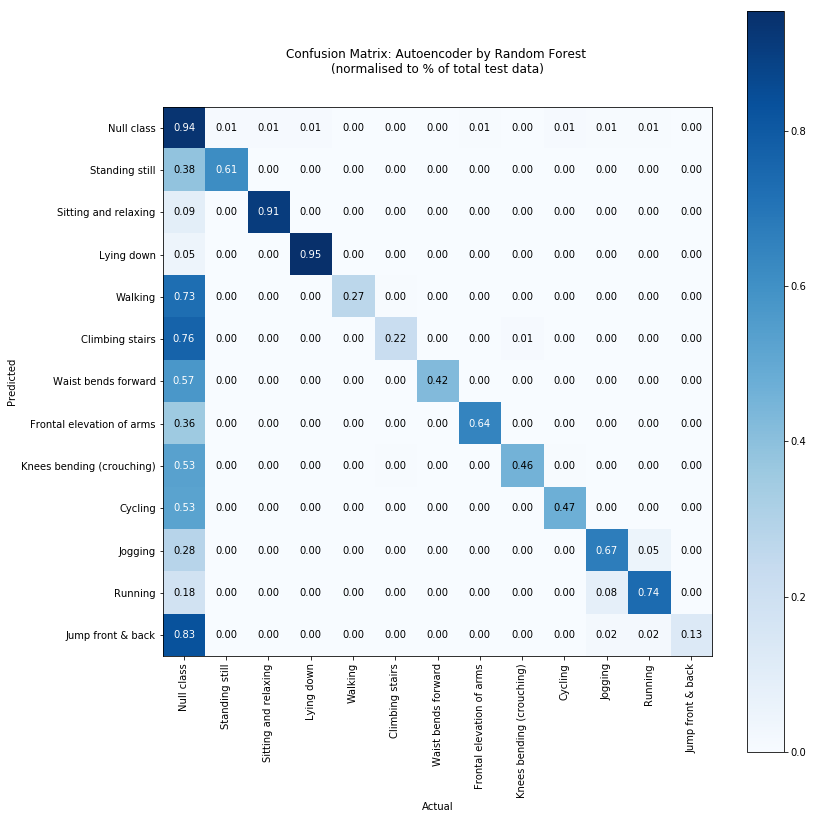

In [ ]:
# Import libraries
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# Convert cm to array for multiclass cm
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100
multiclass = normalised_confusion_matrix

# labels (classes)
classes = ["Null class", "Standing still", "Sitting and relaxing","Lying down", "Walking","Climbing stairs", "Waist bends forward","Frontal elevation of arms", "Knees bending (crouching)","Cycling", "Jogging","Running", "Jump front & back"]

# plot confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                               figsize = (12,12))

# plot title, xaxis and yaxis, identify tickmarks, ensure tight layout
plt.title('Confusion Matrix: Autoencoder by Random Forest \n(normalised to % of total test data)')
plt.xlabel("Actual")
plt.ylabel("Predicted")
tick_marks = np.arange(13)
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

classes = ["Null class", "Standing still", "Sitting and relaxing","Lying down", "Walking","Climbing stairs", "Waist bends forward","Frontal elevation of arms", "Knees bending (crouching)","Cycling", "Jogging","Running", "Jump front & back"]

print(classification_report(y_test, y_pred, target_names=classes))

                           precision    recall  f1-score   support

               Null class       0.85      0.94      0.89    174531
           Standing still       0.73      0.61      0.67      6081
     Sitting and relaxing       0.77      0.91      0.83      6116
               Lying down       0.81      0.95      0.87      6195
                  Walking       0.77      0.27      0.40      6081
          Climbing stairs       0.80      0.22      0.35      6168
      Waist bends forward       0.79      0.42      0.55      5699
Frontal elevation of arms       0.78      0.64      0.70      5829
Knees bending (crouching)       0.80      0.46      0.58      5871
                  Cycling       0.68      0.47      0.56      6109
                  Jogging       0.73      0.67      0.70      6265
                  Running       0.76      0.74      0.75      6116
        Jump front & back       0.69      0.13      0.22      2088

                 accuracy                           0.83    

In [ ]:
# The following feature importance code is taken from this link. 
# https://www.oipapio.com/question-3935333

# import libraries
from xgboost import plot_importance,XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection

# feature importance function
def get_xgb_imp(xgb, feat_names): 
    from numpy import array 
    from pandas import pd
    imp_vals = pd.Series(xgb.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))} 
    total = array(imp_dict.values()).sum() 
    return {k:v/total for k,v in imp_dict.feat_names()} 

# import libraries
import numpy as np 
from xgboost import XGBClassifier 

# Set number of estimators
xgb = XGBClassifier(n_estimators=100) 

# feature importance train test split
X_train,X_test,y_train,y_test=model_selection.train_test_split(features,labels,test_size=0.2)

# fit the model, set evaluation set and early stopping rounds
xgb = xgb.fit(X_train,y_train,early_stopping_rounds=5,eval_set=[(X_test,y_test)])

[0]	validation_0-merror:0.25201
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.251685
[2]	validation_0-merror:0.250336
[3]	validation_0-merror:0.250558
[4]	validation_0-merror:0.250365
[5]	validation_0-merror:0.249575
[6]	validation_0-merror:0.249814
[7]	validation_0-merror:0.249929
[8]	validation_0-merror:0.249612
[9]	validation_0-merror:0.249246
[10]	validation_0-merror:0.249271
[11]	validation_0-merror:0.249222
[12]	validation_0-merror:0.24865
[13]	validation_0-merror:0.248272
[14]	validation_0-merror:0.245767
[15]	validation_0-merror:0.243579
[16]	validation_0-merror:0.240754
[17]	validation_0-merror:0.239836
[18]	validation_0-merror:0.239347
[19]	validation_0-merror:0.238722
[20]	validation_0-merror:0.237998
[21]	validation_0-merror:0.237718
[22]	validation_0-merror:0.235354
[23]	validation_0-merror:0.235049
[24]	validation_0-merror:0.234617
[25]	validation_0-merror:0.234005
[26]	validation_0-merror:0.233421
[27]	validation_0-merror:0.2

    feature  importance
3       f8         780
4      f18         720
5      f15         682
10      f2         594
1      f17         585
8      f19         560
9      f11         510
2      f14         472
0       f0         454
7       f7         449
6      f10         433
11      f9         397
13     f16         373
15     f22         336
12     f20         274
16      f6         253
18     f13         236
20     f12         199
14      f1         163
17     f21         155
19      f5         149
21      f4          96
22      f3          40


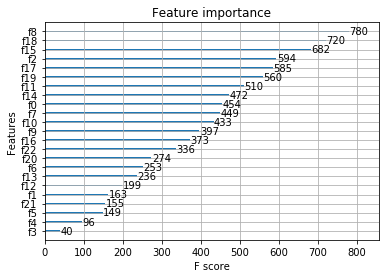

In [ ]:
# import library
import pandas as pd

# fit model
xgb_model=xgb.fit(X_train,y_train)

# convert to pandas dataframe. assign 'feature' and 'importance columns'
xgb_fea_imp=pd.DataFrame(list(xgb_model.get_booster().get_fscore().items()),
                                           
columns=['feature','importance']).sort_values('importance', ascending=False)

# print feature importance for each attribute
print('',xgb_fea_imp)

# convert to csv
#xgb_fea_imp.to_csv('xgb_fea_imp.csv')

# plot importance
from xgboost import plot_importance
plot_importance(xgb_model, )